In [8]:
import numpy as np
from numpy.typing import NDArray

# The functions have been filled in here as an example

def create_U(u: NDArray[np.float64]) -> float:
    U = max(u)                  # Re-write this line to calculate U as a function of u
    return U

def create_Re(x: float, U: float, nu: float) -> float:
    Rex = U*x/nu                # Re-write this line to calculate Re as a function of x,U,nu
    return Rex

def create_VoU(u: NDArray[np.float64], y: NDArray[np.float64], U: float, x: float) -> float:
    VoU = np.trapz(1-u/U,y)/x   # Re-write this line to calculate V/U as a function of u,U,x,y
    return VoU

def create_d2(u: NDArray[np.float64], y: NDArray[np.float64], U: float, x: float) -> float:
    d2 = np.trapz(np.multiply(u/U,1-u/U),y)   # Re-write this line to calculate U as a function of u
    return d2   

# d99 is done for you
def create_d99(u: NDArray[np.float64], y: NDArray[np.float64], U: float, x: float) -> float:
    threshold = U * 0.99
    index99 = max(i for i, v in enumerate(u) if v < threshold)
    d99 = y[index99]
    return d99



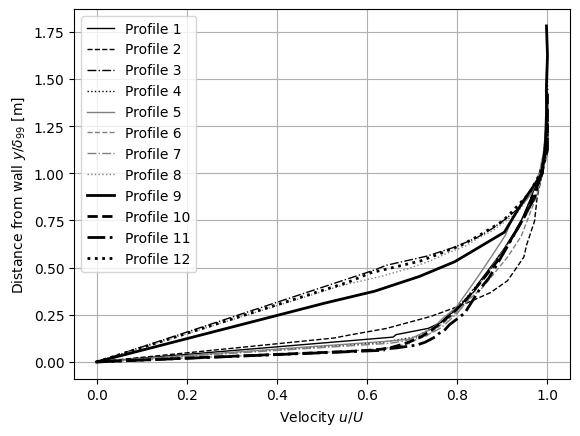

In [3]:
import numpy as np
from numpy import genfromtxt
import glob
import matplotlib.pyplot as plt
import itertools
# Initialise parameters

## Fluid properties
nu=1.5e-5;          #[m2/s] Kinematic viscosity of air at 20C https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm

## Parametric data (from main spreadsheet)
f =      np.array([ 20,  20,  20,   20,   30,  30,  30,  30,   20,   20,   20,   30]);   #[Hz] Fan frequency
x = 1e-3*np.array([300, 500, 500, 1000, 1000, 500, 300, 300,  300, 1000, 1700, 1700]);   #[m]  Streamwise position of each data series
n=len(f);

# Initialise arrays for variables
U=np.zeros(n);Rex=np.zeros(n);VoU=np.zeros(n);d2=np.zeros(n);d99=np.zeros(n) # U, Rex, VoU, d2, d99
z=np.zeros(1) # (this is 'zero')

# Plotting line styles
style_combos = style_combos = [
    ('black', '-', 1), ('black', '--', 1), ('black', '-.', 1), ('black', ':', 1),
    ('gray', '-', 1), ('gray', '--', 1), ('gray', '-.', 1), ('gray', ':', 1),
    ('black', '-', 2), ('black', '--', 2), ('black', '-.', 2), ('black', ':', 2),
    ('gray', '-', 2), ('gray', '--', 2), ('gray', '-.', 2), ('gray', ':', 2)
]

# Iterate through each CSV file
fig, ax = plt.subplots()
for i,fname in enumerate(glob.glob('Profile*.csv')):
    y_vs_u = genfromtxt(fname,delimiter=',')
    u=np.concatenate((z,np.append(0,y_vs_u[:,1])));         #[m/s] Measured velocity, with zero point added
    y=np.concatenate((z,np.append(0,y_vs_u[:,0])));         #[m]   Distance from wall, with zero point added
    U[i]   = create_U(u)                  #[m/s] Freestream velocity
    Rex[i] = create_Re(x[i],U[i],nu)      #[ ]   Reynolds number
    VoU[i] = create_VoU(u,y,U[i],x[i])    #[-] V/U
    d2[i]  = create_d2(u,y,U[i],x[i])     # [m] Momentum thickness assuming straight line to zero
    d99[i] = create_d99(u,y,U[i],x[i])    # [m] Boundary layer thickness at 99% of U
    color, linestyle, linewidth = style_combos[i % len(style_combos)]
    ax.plot(u/U[i], y/d99[i], color=color, linestyle=linestyle, linewidth=linewidth,label=f'Profile {i+1}')

ax.set_xlabel("Velocity $u/U$")
ax.set_ylabel("Distance from wall $y/\delta_{99}$ [m]")
ax.legend()
ax.grid()


In [4]:
# IDentify which profiles are laminar:
idx=np.arange(0,len(f))         # Indices of all points
ilam=np.array([3,8,9, 12])-1;   # For laminar flow (hand picked based on the plot above)
iturb=np.delete(idx,ilam)       # Remaining points for turbulent flow, excluding 10 and 11 in transition.

In [5]:
# Fit a straightline (function will be used later)
def fit_data(x,y):
    m = np.sum(x * y) / np.sum(x**2)    # Least squares fit with intercept = 0
    x_fit = [0, max(x)]                 # Two points is enough to plot a line
    y_fit = np.multiply(m,x_fit)
    return x_fit, y_fit


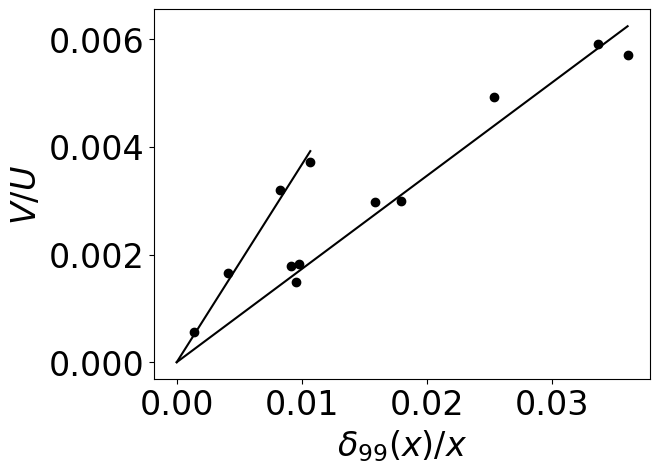

In [6]:
# Potting script
fig, ax = plt.subplots()

d99_o_x=np.divide(d99[idx],x[idx])  # Calculate d99/x
x_lam,  y_lam  = fit_data(d99_o_x[ilam], VoU[ilam])     # Fit the laminar data
x_turb, y_turb = fit_data(d99_o_x[iturb], VoU[iturb])   # Fit the turbulent data

q1 = ax.plot(d99_o_x,VoU,'ko')                          # Plot the data points 
q2 = ax.plot(x_lam,y_lam,'k',x_turb,y_turb,'k')         # Plot the fits

# Format the plot
fsa=24
ax.set_xlabel('$\delta_{99}(x)/x$',fontsize=fsa)
ax.set_ylabel('$V/U$',fontsize=fsa)
ax.tick_params(axis='both', which='major', labelsize=fsa)


In [7]:

fig.savefig( 'figures/VoU_vs_dox_2021_py.png', bbox_inches='tight')